# Generating Hegelian Sentences using a Character-Level RNN

<img src=https://images-na.ssl-images-amazon.com/images/I/41YWGZoiWuL._SX322_BO1,204,203,200_.jpg
 height="300"> <img src=https://cdn.britannica.com/68/195868-050-BFBDC077/engraving-Georg-Wilhelm-Friedrich-Hegel-Lazarus-Gottlieb.jpg height="300">

```
  In order to see the difference of dreaming and waking we need only keep in view
  the Kantian distinction between subjectivity and objectivity of mental representation 
  (the latter depending upon determination through categories): remembering,
   as already noted, that what is actually present in mind need not be therefore 
  explicitly realised in consciousness...

 The self-consciousness of the other is subjective only the same to the form of the
  principle of the object is the proposition of such and the something in the expressed
   in the other and the form of not...
```



---



# Introduction

This project seeks to develop and test a character-level RNN that is capable of producing sentences in the style of the German philosopher Georg Wilhelm Friedrich Hegel. The base model and structure was taken from an old PyTorch tutorial on building a character-level RNN that generates Shakespearean prose. Additions were made to the base structure to test the effect of different model architectures and hyperparameters, including various types of RNN cells, weight initializers, and weight activations.

## Environment Setup

Loads and installs necessary packages, mounts to Google Drive in order to access the data file.

In [0]:
# load and install packages
!pip install -q unidecode
!pip install torchviz
import unidecode
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math

In [0]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

English text translations of Hegel's *Philosophy of Mind* and *Lectures on the History of Philosophy* were retrieved from Project Gutenberg. Some manual cleaning of the data was done to remove footnotes, table of contents, and translator introductions, leaving only the primary text with headings.

Some noise exists in the data, due to some words being framed by unicode characters (possibly the result of the original words being italicized in the source text). However, this did not appear to significantly interfere with training the model, as the best predictions were free of unusual characters.

The data is stored in a plain text file, and any unicode characters are converted into plain ASCII by using the `unidecode` package.

In [0]:
# import data as a long string
file = unidecode.unidecode(open('/content/drive/My Drive/data/hegel.txt', encoding="utf8").read())
file_len = len(file)
print('Total characters in file:', file_len)

Total characters in file: 2273465


As seen above, we have about 2.3 million characters in total. In total, there are approximately 380,000 words.

## Character Representation, Inputs, and Targets 

`all_characters` provides the list of characters that the model will recognize

`n_characters` gives the total number of distinct characters

In [0]:
all_characters = string.printable
n_characters = len(all_characters)
print(all_characters)
print(n_characters)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

100


Text will be turned into a `LongTensor` by looping through the characters of the string and retrieving the index of each character in `all_characters`, thereby representing each character using and integer.

In [0]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))
print(char_tensor('dispute '))

tensor([10, 11, 12, 39, 40, 41])
tensor([13, 18, 28, 25, 30, 29, 14, 94])


The below functions pull a random chunk of text and prepares input and target tensors for training. Inputs will consist of a string of characters whose target is the characters immediately following the input characters.

For example, if the text chunk is 'essential object', the input is 'essential objec' and the target is 'ssential object'. Thus, input-target pairings are as follows:

'e' -> 's'

's' -> 's'

's' -> 'e'

'e' -> 'n'

'n' -> 't'

't' -> 'i'

'i' -> 'a'

'a' -> 'l'

'l' -> [space character]


In [0]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

print(random_chunk())


the bond which holds the state together, that which gives the state
its power, from principles which lie within us, which we recognize as
our own. In this way two opposite principles arise. The first 




---



# The Models

## Key Features

Features tested in the model predominantly focused on the following:



*   Cell types
    *   Elman RNN (tanh and relu activations), GRU, LSTM
*   Model depth
    *   1, 2, 3 layers with the RNN cell
*   Weight initializations
    *   Normal, Orthonormal, Kaiming Uniform, Xavier Uniform

For the sake of simplicity, several hyperparameters were held constant. All models used a constant learning rate of 0.001, an Adam optimizer, and a Cross Entropy loss function. The width of the hidden layers was also held constant, as the structure of the model requires that the number of hidden layers be equal to the number of characters recognized by the model.



## A Guide to the Network Class Functions

**`forward`**

Calls the forward pass.

**`train`**

A training function that initializes weights for the hidden state, zeros gradients at each pass, updates weights for the model, and returns an averaged loss for each chunk of text.

**`init_hidden`**

Initializes weights for the hidden state, and distinct from the weight initializer for the model itself. To simplify the testing process, the same weight initializer was generally used for the hidden state, cell state (for LSTMs), and model weights.

**`Evaluation`**

The network's ability to generate sentences will be tested by feeding the network a string of characters. The network will use its trained outputs as a probability distribution to predict the next character, and repeat for the prescribed string length. To start generation, we pass a priming string to start building up the hidden state and then generate the next character one at a time.

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='tanh') #  tested both 'tanh' or ‘relu’ activations
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        #output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def train(self, inp, target):
        hidden = self.init_hidden()
        self.zero_grad()
        loss = 0

        for c in range(chunk_len):
            output, hidden = self(inp[c], (hidden))
            loss += criterion(output, target[c].unsqueeze(0))

        loss.backward()
        model_optimizer.step()
        return loss.data / chunk_len

    def init_hidden(self):
        return nn.init.orthogonal_(torch.zeros(self.num_layers, 1, self.hidden_size))
        # nn.init.normal_()
        # nn.init.orthogonal_()
        # nn.init.xavier_uniform_(tensor, gain=1.0)
        # nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='relu')

    def evaluate(self, prime_str='A', predict_len=100, temperature=0.5):
        hidden = self.init_hidden()
        prime_input = char_tensor(prime_str)
        predicted = prime_str

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            _, hidden = self(prime_input[p], hidden)
        inp = prime_input[-1]
        
        for p in range(predict_len):
            output, hidden = self(inp, hidden)
            
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            
            # Add predicted character to string and use as next input
            predicted_char = all_characters[top_i]
            predicted += predicted_char
            inp = char_tensor(predicted_char)
        return predicted

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, cell):
        input = self.encoder(input.view(1, -1))
        output, (hidden, cell) = self.lstm(input.view(1, 1, -1), (hidden, cell))
        output = self.decoder(output.view(1, -1))
        return output, (hidden, cell)

    def train(self, inp, target):
        hidden, cell = self.init_hidden()
        self.zero_grad()
        loss = 0

        for c in range(chunk_len):
            output, (hidden, cell) = self.forward(inp[c], hidden, cell)

            loss += criterion(output, target[c].unsqueeze(0))

        loss.backward()
        model_optimizer.step()
        return loss.data / chunk_len
    
    def init_hidden(self):
        hidden = nn.init.normal_(torch.zeros(self.num_layers, 1, self.hidden_size))
        cell =  nn.init.normal_(torch.zeros(self.num_layers, 1, self.hidden_size))
        return hidden, cell
        # nn.init.normal_()
        # nn.init.orthogonal_()
        # nn.init.xavier_uniform_(tensor, gain=1.0)
        # nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='relu')

    def evaluate(self, prime_str='A', predict_len=100, temperature=0.5):
        hidden, cell = self.init_hidden()
        prime_input = char_tensor(prime_str)
        predicted = prime_str

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            _, (hidden, cell) = self(prime_input[p], hidden, cell)
        inp = prime_input[-1]
        
        for p in range(predict_len):
            output, (hidden, cell) = self(inp, hidden, cell)
            
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            
            # Add predicted character to string and use as next input
            predicted_char = all_characters[top_i]
            predicted += predicted_char
            inp = char_tensor(predicted_char)
        return predicted       

## Helper Functions

**`time_since`**

Provides the time elapsed over selected time increments. Later, this will be used to track the amount of time required to train, at intervals of every 100 epochs.

In [0]:
# a function that prints the amount of time passed
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

**`init_weights`**

Initializes weights for the linear layer.

In [0]:
def init_weights(module):
    if isinstance(module, nn.Linear):
          print("initializing weights")
          nn.init.orthogonal_(module.weight)
          nn.init.zeros_(module.bias)
          # nn.init.normal_
          # nn.init.orthogonal_
          # nn.init.xavier_uniform_
          # nn.init.kaiming_uniform_(tensor, nonlinearity='relu')

## Training the RNN Model

The below defines the training parameters, instantiates the model, initializes model weights, and starts training.

RNN and GRU models were trained for 3000 epochs.

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = n_characters
hidden_size = 100
cell_size = 100
n_layers = 3
lr = 0.001

model = RNN(input_size, hidden_size, input_size, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()

initializing weights


In [0]:
print(model)

RNN(
  (encoder): Embedding(100, 100)
  (gru): GRU(100, 100, num_layers=3)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)


In [0]:
# the main training function
def training_function(model,model_optimizer,n_epochs, print_every, plot_every):
    start = time.time()
    all_losses = []
    loss_avg = 0
    
    for epoch in range(1, n_epochs + 1):
        loss = model.train(*random_training_set())       
        loss_avg += loss

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(model.evaluate('Wh', 100), '\n')

        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_avg = 0

    return all_losses

In [0]:
n_epochs = 3000
print_every = 100
plot_every = 10

rnn_losses = training_function(model,model_optimizer,n_epochs, print_every, plot_every)

 31s (100 3%) 2.8264]
Whinue ot ctts eare titre on ahrhe iih tetrne ou tin tan aor itr ns tst tah ans oe twe tn te ae ob ane 

 3s (200 6%) 2.1535]
White the ald of to pase the is of the the as phe fo of fhtend the prithe as in and and the mang the s 

 35s (300 10%) 2.1706]
Whing and and the a of and the the there erthe it precerlites is the the the a deall a not is the ang  

 6s (400 13%) 2.7368]
Wh unded in the the and the conter a sof a septeratelo ade potence as a seing sond and form withect st 

 36s (500 16%) 1.7854]
Whic of the Stirissophic of not the soment is of setived and the pleming and the an and of the pheren  

 7s (600 20%) 1.8709]
Wher of the stent acting is soutions all of the sall the the subject it not of the post of the sall so 

 37s (700 23%) 1.8634]
Whes is serelation, orded the one the senses and the minds not in the stint the senses and itself the  

 7s (800 26%) 1.6660]
Whenting and to a seconceptions is the as all the specal is the existent and to the wor

## Training the LSTM Model

Given notable differences in architecture, below is the training process for the LSTM model.

LSTM models consistently required more epochs to reach convergence similar to the RNN and GRU models, and were trained for 6000 epochs.

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = n_characters
hidden_size = 100
cell_size = 100
n_layers = 3
lr = 0.001

model = LSTM(input_size, hidden_size, input_size, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()

In [0]:
print(model)

In [0]:
n_epochs = 6000
print_every = 100
plot_every = 10

lstm_losses = training_function(model,model_optimizer,n_epochs, print_every, plot_every)



---



# Outcomes and Assessment

Given the subjective nature of this task, numerical metrics are an incomplete placeholder for success. A combination of numerical and qualitative characteristics were used for assessment.

All models used a CrossEntropy function for the purposes of model training. While an incomplete measure of success, this generally did yield models that were able to construct coherent words--even if a more coherent syntax is still elusive.

Also considered was the ability of the algorithm to construct actual words in the English language (rather than mispelled or almost-words), syntactical structure, and variation in word choice.

## Plotting the Training Losses

The majority of models tested achieved a loss around 1.5 regardless of its "success" in constructing words or sentences. Few reached a loss value much higher or lower.

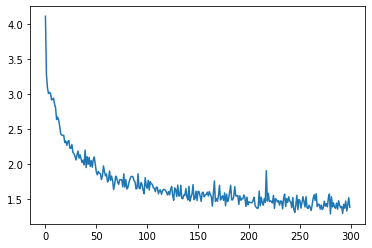

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(rnn_losses)
#lstm_losses
#rnn_losses

## The Temperature Gauge

In the `evaluate` function, each time a prediction is made the outputs are divided by the "temperature". Higher values thus render all predicted values more equally likely, and thus gives us "more random" outputs. Lower temperatures (less than 1) choose the more probable character outputs.

Interestingly, at the lowest temperatures (around .2), predictions result in nearly all coherent words, but predominantly filler words such as "the," "as," and "it", and phrased repeated several times over. For example:

> "The existent is the more the self-consciousness of the such is the such the self-consciousness in the self-consciousness the same to the self-conscious the some the self-consciousness of the self-consci"

Middling temperatures such as .4-.6 generally yielded the best results, varying the word choice with fillers as well as nouns, verbs, and other types of words, while yielding a relatively large number of actual words. An example: 

> "There and the same and senseption is a subject perfect with the self-consciousness as a makes the principle freedom of the same as itself and the senses and the soul in a something as a senses of the sa"

In [0]:
print(model.evaluate('Th', 200, temperature=0.4))

There and the same and senseption is a subject perfect with the self-consciousness as a makes the principle freedom of the same as itself and the senses and the soul in a something as a senses of the sa


Higher temperatures choose less probable outputs, producing predictions that are garbled and largely incoherent:

In [0]:
print(model.evaluate('Be', 200, temperature=1.2))

Bedies ow Eaelling; the
putality
to the Words notion that them.

IndiEst it as were there assuom_ discan a
ppositive; and refusated make moits in leaculalction' dutise would Heading in itleave this, on 


## Saving Models

The below was used to save the model results and losses for later prediction.

In [0]:
# use rnn_losses or lstm_losses
# 1 is RNN, 2 is LSTM
def save_checkpoint(losses, model_type):
    if model_type == 1:
        checkpoint = {'model': RNN(n_characters, hidden_size, n_characters, n_layers),
              'state_dict': model.state_dict(),
              'optimizer' : model_optimizer.state_dict(),
              'losses': losses}
    if model_type == 2:
        checkpoint = {'model': LSTM(n_characters, hidden_size, n_characters, n_layers),
            'state_dict': model.state_dict(),
            'optimizer' : model_optimizer.state_dict(),
            'losses': losses}
    return checkpoint

In [0]:
#checkpoint = save_checkpoint(rnn_losses,1)

#torch.save(checkpoint, 'drive/My Drive/saved_models/514_RNN2_orthogonal_3000')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Best Models

In general, many models were able to construct coherent words in the English language, especially words that are distinctive to philosophical writings such as being "being", "consciousness," "self," "external," "form," and "universal." Models also successfully constructed certain verbs and connecting words such as "seen," "as," "and," and "that." The best models found were relatively free of garbled words.

Models struggled more with syntactical structure and variation in word choice. The best models found were able to string together several words with a semi-coherent syntax. However, none were able to construct whole thoughts or sentences. Variation in word choice was reasonably good in the best models, whereas in most cases a model commonly would repeat the same phrase several times over in the same "sentence."

Punctuation was also a challenge. The models tested did not yield any coherent sentences with proper placement of grammatical marks such as commas or periods. Most rarely used punctuation at all.

The minimum loss attained was similar across all best models.



In [0]:
# function to load models
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    losses = checkpoint['losses']
    return model, losses

### Model 1: GRU, 3 layers, orthogonal initialization

In [0]:
gru1_model, gru1_losses = load_checkpoint('drive/My Drive/saved_models/514_RNN2_orthogonal_3000')

As shown below, the model retrieved is a GRU with 2 layers.

In [0]:
print(gru1_model)

RNN(
  (encoder): Embedding(100, 100)
  (gru): GRU(100, 100, num_layers=2)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)


The third best among those shown, this model general yields relatively coherent strings of words when at a temperature of 0.4--though inconsistently so and with several misspelt words throughout.

An example:
> 'The substance of the one and and the conception of the thing is not philosophy of the one the and the different to be subjective as the ideas of the law to the impossition of the one of the one are as th'

In [0]:
gru1_model.evaluate('The', 200, temperature=0.4)

'The substance of the one and and the conception of the thing is not philosophy of the one the and the different to be subjective as the ideas of the law to the impossition of the one of the one are as th'

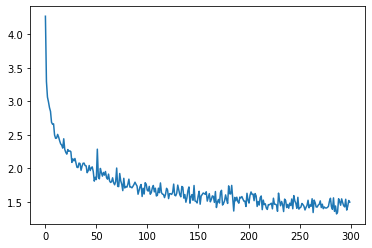

In [0]:
plt.figure()
plt.plot(gru1_losses)

### Model 2: LSTM, 3 layers, Xaiver/Kaiming Uniform initialization

The Xaiver Uniform distribution was used for initialization of the hidden and cell weights, and Kaiming Uniform used for the linear layer weights. This combination was accidental due to user error (as systematic testing intended to use the same initializations for model weights and hidden and cell weights), but suggests that further exploration might consider varying the combination of activations used.

In [0]:
lstm1_model, lstm1_losses = load_checkpoint('drive/My Drive/saved_models/514_LSTM3_kaiming_6000')

In [0]:
print(lstm1_model)

LSTM(
  (encoder): Embedding(100, 100)
  (lstm): LSTM(100, 100, num_layers=3)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)


Results here are also inconsistent, but at a temperature of 0.4 the model sometimes produces a relatively coherent string of words with varied word choices.

An example:

> 'The form is the self-consciousness, the man in the sense is the matter is then production of the property of the finitude of its subjective of the something the active only the same therefore the sense, '

In [0]:
lstm1_model.evaluate('The', 200, temperature=0.4)

'The form is the self-consciousness, the man in the sense is the matter is then production of the property of the finitude of its subjective of the something the active only the same therefore the sense, '

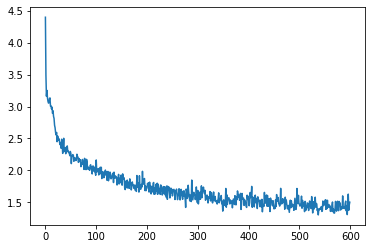

In [0]:
plt.figure()
plt.plot(lstm1_losses)

### Model 3: LSTM, 3 layers, Normal initialization


In [0]:
lstm2_model, lstm2_losses = load_checkpoint('drive/My Drive/saved_models/514_LSTM3_normal_6000')

In [0]:
print(lstm2_model)

LSTM(
  (encoder): Embedding(100, 100)
  (lstm): LSTM(100, 100, num_layers=3)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)


The best model among those tested, this model fairly consistently outputs a semi-coherent string of words with varied word choice and nearly all coherent words.

An example:
> 'There is the sense-position of the unity of the reflection of God as the principle of the relation of the Notion, in the soul as a mental passive content of the senses, and the the same the necessity and'





In [0]:
lstm2_model.evaluate('The', 200, temperature=0.4)

'The reason to the different distinction, and the really the sense is its ender therefore the Notion of the content is a content of the principle of the moral with the power the one and related to the con'

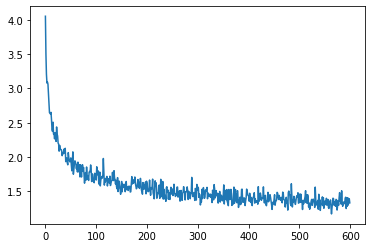

In [0]:
plt.figure()
plt.plot(lstm2_losses)



---



# Conclusions and Follow-Up

### Observations and Lessons Learned

Of the models tested, more layers generally performed better, though when tested the predictive performance of four or five layers were not significantly or notably better than three, suggesting that sheer depth does not by itself produce superior results.

In most cases, one weight initialization was not consistently better than another, as is somewhat illustrated by the fact that the best models found each use different initializations. GRU did seemed to generally perform better when paired with orthogonal weights.

Somewhat unsurprisingly given the interest of this project in syntax and word variation, GRUs and LSTMs generally performed better than RNNs (relu or tanh activations). Their short and long-term memory abilities likely added significantly to the ability to construct coherent words and vary word choice.

The current structure of the model does not allow the user to vary hidden vector sizes, as input sizes for training must match the number of letters represented by the model. However, further testing might consider varying the cell size in LSTMs to gauge its impact on model results.

### Follow-up work

Given the results of Model 2, further exploration might consider varying the combination of activations used for the linear layer and RNN layer weights. Variations in the size of the cell state within LSTMs might also be worth exploring, given the prominent role of the cell state in containing model information. Training the initial state may also be very valuable for improving the starting point that the models are training from.



---



# Sources

* [Practical PyTorch: Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/tree/master/char-rnn-generation), Sean Robertson
* [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
* [Tutorial: Bidirectional Recurrent Neural Network](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/bidirectional_recurrent_neural_network/main.py), Yunjey Choi
* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/), Christopher Olah
